### This code is to implement bi-directional sweeps in the HD attractor network

In [1]:
import numpy as np
import brainpy.math as bm
import matplotlib.pyplot as plt
from network import HD_cell
from scipy.ndimage import gaussian_filter

import sys
sys.path.append('/home/zilong/Desktop/HDPhasePrecession/CircularLinearReg')
from core import cl_corr

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/zilong/anaconda3/envs/HDPhasePrecession/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Plot functions

In [2]:
def generate_traj_hd(x0, v, T, var=1):
    x = []
    xt = x0
    for i in range(T):
        xt = xt + v * (1 + var*np.random.randn(1)) * bm.dt
        if xt > np.pi:
            xt -= 2 * np.pi
        if xt < -np.pi:
            xt += 2 * np.pi
        x.append(xt)
    return np.array(x)

# Function to apply circular smoothing
def circular_smoothing(angles, sigma):
    """
    Apply Gaussian smoothing to a 1D array of angular data.
    
    Parameters:
    angles (1D array): Array of angles in radians or degrees (but consistent)
    sigma (float): The standard deviation for Gaussian kernel.
    
    Returns:
    smoothed_angles (1D array): Smoothed angular data.
    """
    
    # Convert to Cartesian coordinates
    sin_vals = np.sin(angles)
    cos_vals = np.cos(angles)
    
    # Apply Gaussian smoothing to sine and cosine components
    smoothed_sin = gaussian_filter(sin_vals, sigma=sigma, mode='wrap')
    smoothed_cos = gaussian_filter(cos_vals, sigma=sigma, mode='wrap')
    
    # Recompute the angle from the smoothed sine and cosine
    smoothed_angles_rad = np.arctan2(smoothed_sin, smoothed_cos)

    
    return smoothed_angles_rad

def compute_autocorrelation(fr_array, bin_size=0.001, max_lag=0.5, ifclip=True):
    # Number of bins for the max_lag
    max_lag_bins = int(max_lag / bin_size)
    autocorr = np.correlate(fr_array, fr_array, mode='full')
    mid_point = len(autocorr) // 2
    autocorr = autocorr[mid_point - max_lag_bins: mid_point + max_lag_bins + 1]
    
    # Normalize the autocorrelation values
    lags = np.arange(-max_lag_bins, max_lag_bins + 1) * bin_size  # Lags in seconds
    
    if ifclip:
        idx_range = np.where((lags >= 0.05) & (lags <= 0.25))[0]
        max_value = np.max(autocorr[idx_range])
        autocorr = autocorr / max_value
        autocorr = np.clip(autocorr, a_min=None, a_max=1)
    else:
        pass
    lags_ms = lags * 1000  # Convert to ms
    
    # Convert autocorr, lags into a 2*n array
    return np.array([autocorr, lags_ms])

def plot_populationsweep(ax, t, Head_direction, bump_activity, addcbar=True):
    
    labelsize=10
    ticksize=8
    # imshow and smooth
    ax.imshow(bump_activity.T*100, aspect='auto', extent=[t[0], t[-1], -bm.pi, bm.pi], cmap='inferno', origin='lower')
    
    #plot the head direction as a line
    ax.plot(t, Head_direction, color='white', lw=2)
    
    if addcbar:
        #add colorbar
        cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', pad=0.02)
        cbar.set_label('Activity (Hz)', fontsize=ticksize)
        #set ticks
        cbar.ax.set_yticks([0, int(np.max(bump_activity)*100/10)*10])

        cbar.ax.tick_params(labelsize=ticksize)
    else:
        pass
    
    #xticks
    ax.set_xticks([t[0], t[-1]])
    ax.set_xticklabels([t[0]-t[0], t[-1]-t[0]])
    #yticks
    ax.set_yticks([-bm.pi, 0, bm.pi])
    ax.set_yticklabels([r'$0\degree$', r'$180\degree$', r'$360\degree$'])
    
    #label
    ax.set_xlabel('Time (ms)', fontsize=labelsize)
    ax.set_ylabel('Direction', fontsize=labelsize)
    #ticksize
    ax.tick_params(axis='both', which='major', labelsize=ticksize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax

def plot_phaseprecession(ax, cellindex, HD_activity, Head_direction, theta_phase, addfitline=True):
    
    labelsize=10
    ticksize=8
    
    hd_spike = []
    tp_spike = []
    #for each Head_direction, theta_phase pair, generate a spike event based on a Poisson process with mean value as r_HD
    for i in range(len(Head_direction)):
        hd = Head_direction[i,0]
        tp = theta_phase[i]
        r = HD_activity[i, cellindex]/10
        #genertae a spike event based on a Poisson process with mean value as r
        spikes = np.random.poisson(r, 1)
        if spikes > 0:
            #save hd and tp
            hd_spike.append(hd)
            tp_spike.append(tp)
    hd_spike = np.array(hd_spike)
    tp_spike = np.array(tp_spike)

    ax.scatter(hd_spike, tp_spike, s=3, color='black', alpha=0.3)

    ax.scatter(hd_spike, tp_spike+2*np.pi, s=3, color='black', alpha=0.3)
    
    ax.axvline(x=0, color='#009FB9', linestyle='--', linewidth=2, label = 'preferred direction')

    circ_lin_corr, pval, slope, phi0, RR = cl_corr(hd_spike, tp_spike, min_slope=-1, max_slope=0, bootstrap_iter=3000, return_pval=True)
    
    if addfitline:
        # Plot the circular-linear regression
        x = np.linspace(-np.pi, np.pi, 100)
        y = 2 * np.pi * slope * x + phi0
        ax.plot(x, y, color='red', linewidth=1)
        #add intercepr of 2*pi, and plot the line again
        y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
        ax.plot(x, y, color='red', linewidth=1)
        #add intercepr of 4*pi, and plot the line again
        y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
        ax.plot(x, y, color='red', linewidth=1)
        #substrac intercepr of 2*pi, and plot the line again
        y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
        ax.plot(x, y, color='red', linewidth=1)       

    # ax[0].set_xlabel('Head direction')
    ax.set_xlabel('Turning angle', fontsize=labelsize)
    ax.set_ylabel('Theta phase', fontsize=labelsize)
    #activity colorbar
    ax.set_xlim(-0.5*np.pi, 0.5*np.pi)
    ax.set_xticks([-0.5*np.pi, 0, 0.5*np.pi])
    ax.set_xticklabels([r'$-\pi/2$', r'$0$', r'$\pi/2$'])
    ax.set_ylim(0, 4*np.pi)
    ax.set_yticks([0, 2*np.pi, 4*np.pi])
    ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])

    #tick size
    ax.tick_params(axis='both', which='major', labelsize=ticksize)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return ax, circ_lin_corr, slope

def plot_autocorrelation(ax, autocorr_r_probe):
    
    labelsize=10
    ticksize=8
    
    ax.plot(autocorr_r_probe[1,:], autocorr_r_probe[0,:], color='black', linewidth=1)
    #fill betwwen autocorr_r_probe and np.min(autocorr_r_probe)
    ax.fill_between(autocorr_r_probe[1,:], autocorr_r_probe[0,:], np.min(autocorr_r_probe[0,:]), color='black', alpha=1.0)

    # ax.set_xlim(-500, 500)
    ax.set_ylim(np.min(autocorr_r_probe[0,:]), 1)
    ax.set_yticks([])
    ax.set_xlabel('Lag (ms)', fontsize=labelsize)   
    ax.set_ylabel('')
    # ax.set_title('Autocorrelation', fontsize=ticksize)

    #ticksize
    ax.tick_params(axis='both', which='major', labelsize=ticksize)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    return ax


## Section 1: define the network

In [3]:
bm.set_dt(1.)

HD_net = HD_cell(num=100, 
                noise_stre=0.6, 
                tau=10., tau_v=100., 
                k=1., mbar=15, a=0.4, A=3., J0=4., 
                z_min=-bm.pi, z_max=bm.pi)

def run_HDNet(i, Head_direction, angular_velocity_gain):  # 20 x size

    T_theta = 100 #ms
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta
    #calculate TheataModulator at time step i
    ThetaModulator_HD = 1+(0.2+0.02*angular_velocity_gain)*bm.cos(theta_phase*2*bm.pi)
    HD_net.step_run(i, Head_direction, ThetaModulator_HD)
    Internal_direction = HD_net.center
    bump_activity = HD_net.r
    return Internal_direction, bump_activity, theta_phase

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Section 2: simulate the HD network when head direction is fixed

100%|██████████| 4000/4000 [00:00<00:00, 15921.71it/s]


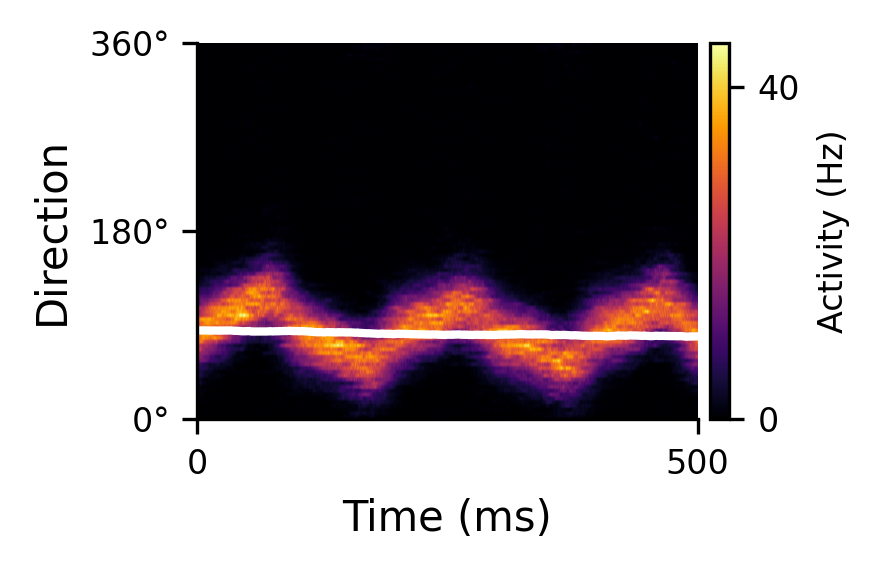

In [49]:
np.random.seed(0)

numT = 4000 #ms
x0 = -0.5*np.pi

time_steps = np.arange(numT)
angular_velocity_gain = -0.05
angular_velocity = angular_velocity_gain*np.pi/(1e3)

Head_direction = generate_traj_hd(x0=x0, v=angular_velocity, T=numT, var=10)

angular_velocity_gain = np.ones_like(Head_direction)*angular_velocity_gain
bump_center, bump_activity, theta_phase = bm.for_loop(run_HDNet, (time_steps, Head_direction, angular_velocity_gain), progress_bar=True)
max_bump_activity = np.max(bump_activity, axis=1)

start = 1000
end = 1500+1


#polor plot in axs[1]
fig, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=300)
ax = plot_populationsweep(ax, 
                        time_steps[start:end], 
                        Head_direction[start:end], 
                        bump_activity[start:end])
plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/HD_sweep_static.pdf', dpi=300)

## Section 3: simulate the network when head direction is rotating at a constant speed

100%|██████████| 4000/4000 [00:00<00:00, 17224.01it/s]


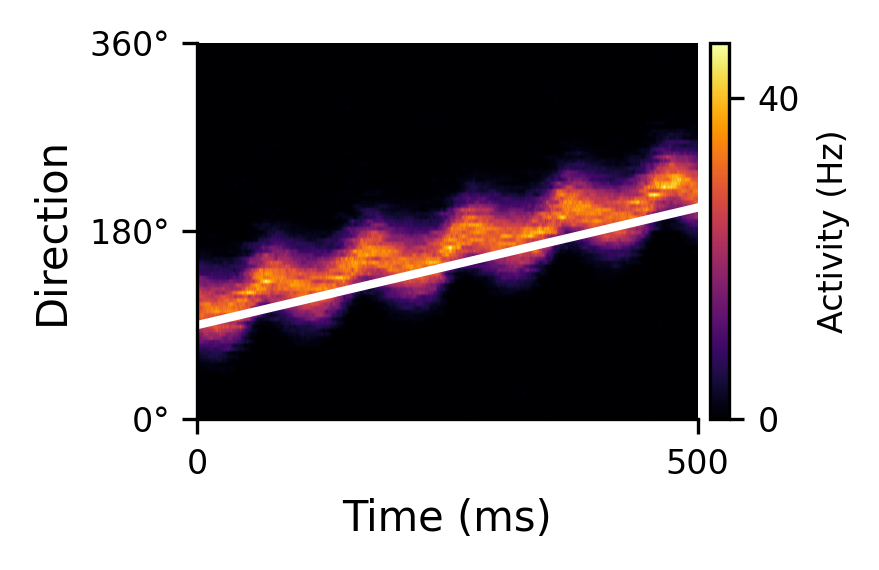

In [48]:
numT = 4000
time_steps = np.arange(numT)
#chaging head direction, mimicking the animal turning
angular_velocity_gain = 5
Head_direction = angular_velocity_gain*bm.pi*bm.arange(numT)/numT
#wrap to 0 to 2pi
Head_direction = bm.mod(Head_direction, 2*bm.pi) - 1.0*bm.pi
angular_velocity_gain = np.ones_like(Head_direction)*angular_velocity_gain
bump_center, bump_activity, theta_phase = bm.for_loop(run_HDNet, (time_steps, Head_direction, angular_velocity_gain), progress_bar=True)
max_bump_activity = np.max(bump_activity, axis=1)

start = 2000
end = 2500+1
#polor

fig, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=300)
ax = plot_populationsweep(ax, 
                        time_steps[start:end], 
                        Head_direction[start:end], 
                        bump_activity[start:end])
plt.tight_layout()
plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/HD_sweep_rotating.pdf', dpi=300)

## Section 4: plot phase precession of turning angle

In [18]:
def simulate(angular_velocity_gain=1, theta_mod_base=0.2, numT=100000):
    
    '''
    0.5, 15, 1: precession HD
    0., 0,, 1: normal HD (no theta tuned)
    3.5, 0, 1: theta tuned no precession 
    '''

    # run network
    
    HD_net = HD_cell(num=100, 
                    noise_stre=1.6, 
                    tau=10., tau_v=100., 
                    k=1., mbar=15, a=0.4, A=3., J0=4., 
                    z_min=-bm.pi, z_max=bm.pi)

    def run_HDNet(i, Head_direction):  # 20 x size

        T_theta = 100 #ms
        t = i*bm.dt
        theta_phase = bm.mod(t, T_theta)/T_theta
        #calculate TheataModulator at time step i
        ThetaModulator_HD = 1+(theta_mod_base+0.2*angular_velocity_gain)*bm.cos(theta_phase*2*bm.pi)
        #ThetaModulator_HD = 1+0*bm.cos(theta_phase*2*bm.pi)
        HD_net.step_run(i, Head_direction, ThetaModulator_HD)
        Internal_direction = HD_net.center
        bump_activity = HD_net.r
        return Internal_direction, bump_activity, theta_phase    
    
    
    angular_velocity = angular_velocity_gain*np.pi/(1e3)
    
    #numT = 100000 #ms
      
    time_steps = np.arange(numT)

    Head_direction = generate_traj_hd(x0=0, v=angular_velocity, T=numT, var=10)
    # plt.figure()
    Head_direction = circular_smoothing(Head_direction, sigma=10)

    center_HD, HD_activity, theta_phase = bm.for_loop(
        run_HDNet, (time_steps, Head_direction), progress_bar=True
    )

    theta_phase = theta_phase*2*np.pi
    max_bump_activity = np.max(HD_activity, axis=1)
    
    return time_steps, Head_direction, center_HD, max_bump_activity, HD_activity, theta_phase




100%|██████████| 200000/200000 [00:01<00:00, 124619.27it/s]


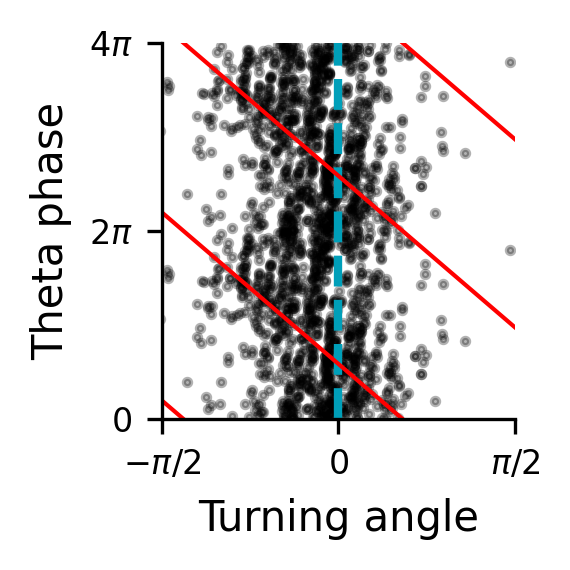

In [19]:
results = simulate(angular_velocity_gain=1, theta_mod_base=0.1, numT=200000)
time_steps, Head_direction, center_HD, max_bump_activity, HD_activity, theta_phase = results

# fig, axs  = plt.subplots(1, 2, figsize=(4, 2), dpi=300, width_ratios=[2, 1])

# ax = axs[0]
# #plot population sweeps
# ax = plot_populationsweep(ax, 
#                         time_steps[0:1000], 
#                         Head_direction[0:1000], 
#                         HD_activity[0:1000], 
#                         addcbar=False)



# ax = axs[1]
fig, ax  = plt.subplots(1, 1, figsize=(2, 2), dpi=300)
cellindex = 50
ax, clr, slope = plot_phaseprecession(ax, cellindex, HD_activity, Head_direction, theta_phase)

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/model_phaseprecession.pdf', dpi=300)

In [20]:
results = simulate(angular_velocity_gain=1, theta_mod_base=0.2)
time_steps, Head_direction, center_HD, max_bump_activity, HD_activity, theta_phase = results



100%|██████████| 100000/100000 [00:00<00:00, 108406.78it/s]


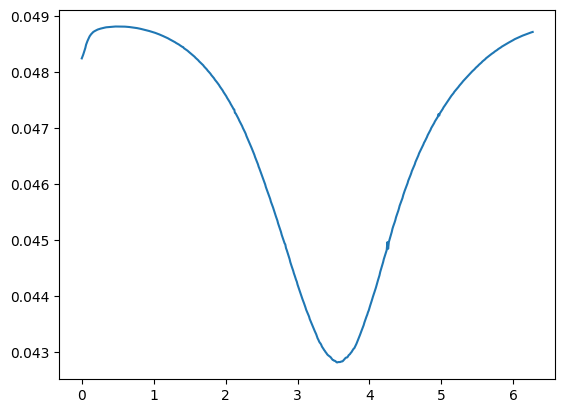

In [34]:
mean_fr = np.mean(HD_activity, axis=1)
#according to theta_phase, bin the mean_fr into 100 bins

bin_size = 0.01
theta_bins = np.arange(0, 2*np.pi+bin_size, bin_size)
theta_bins = theta_bins[:-1]

mean_fr_binned = np.zeros_like(theta_bins)
for i in range(len(theta_bins)):
    idx = np.where((theta_phase >= theta_bins[i]) & (theta_phase < theta_bins[i]+bin_size))[0]
    mean_fr_binned[i] = np.mean(mean_fr[idx])

#plot mean_fr_binned
plt.figure()
plt.plot(theta_bins, mean_fr_binned)


In [33]:
mean_fr_binned.shape

(629,)

## Section 5: plot autocorrelogram

100%|██████████| 100000/100000 [00:00<00:00, 114169.55it/s]


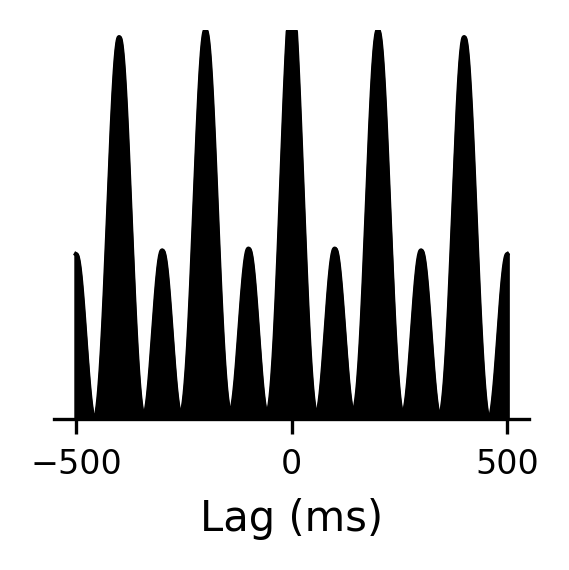

In [61]:
results = simulate(angular_velocity_gain=0.0, theta_mod_base=0.2)
time_steps, Head_direction, center_HD, max_bump_activity, HD_activity, theta_phase = results

probe_index = 52
r_probe = HD_activity[:, probe_index]

autocorr_r_probe =  compute_autocorrelation(r_probe, bin_size=0.001, max_lag=0.5, ifclip=True)

# fig, axs = plt.subplots(1, 2, figsize=(4, 2), dpi=300)

# ax = axs[0]
# ax = plot_populationsweep(ax, 
#                         time_steps[1000:2000], 
#                         Head_direction[1000:2000], 
#                         HD_activity[1000:2000], 
#                         addcbar=False)

# ax = axs[1]
fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=300)
ax = plot_autocorrelation(ax, autocorr_r_probe)

plt.tight_layout()
plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/model_autocorrelation.pdf', dpi=300)

## Section 6: check phase precession with various angular speed

100%|██████████| 100000/100000 [00:00<00:00, 112058.78it/s]


0.06663039514377159 -0.789869475800634


100%|██████████| 100000/100000 [00:00<00:00, 113985.16it/s]


0.02665494123887291 -0.5579843601259472


100%|██████████| 100000/100000 [00:00<00:00, 114602.38it/s]


0.1644721522067373 -4.639013368304785e-06


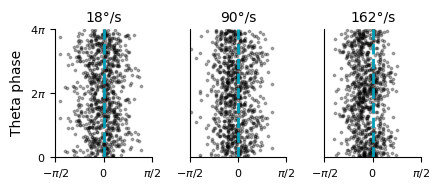

In [88]:
fig, axs = plt.subplots(1, 3, figsize=(4.5, 2.0), dpi=100)

for i, angular_gain in enumerate(np.arange(0.1,1.0,0.4)):
    results = simulate(angular_velocity_gain=angular_gain, theta_mod_base=0.1)
    time_steps, Head_direction, center_HD, max_bump_activity, HD_activity, theta_phase = results

    ax = axs[i]
    cellindex = 50
    ax, clr, slope = plot_phaseprecession(ax, cellindex, HD_activity, Head_direction, theta_phase, addfitline=False)
    #add titke
    ax.set_title(str(int(angular_gain*180))+'°/s', fontsize=10)
    ax.set_xlabel('')
    if i !=0:
        ax.set_ylabel('')
        ax.set_yticks([])
    if i == 1:
        ax.set_xlabel('Turning angle', fontsize=10)
    print(clr, slope)
plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/model_phaseprecession_varyspeed.pdf', dpi=300)